# Impact of the Thomas Fire on AQI in Santa Barbara County, CA (2017)

Author: Oksana Protsukha

Github repository: [thomasfire_aqi_analysis](https://github.com/oksanaprotsukha/thomasfire_aqi_analysis)


## Overview
In this notebook, we are going to analyze the impact of [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire)  on the air quality in Santa Barbara county in 2017. To do so, we will complete the following two tasks: <br>
1. Visualize the Air Quality Index (AQI) in Santa Barbara County for 2017 and 2018.<br>
2. Create a false color image to visualize the Thomas Fire scar.<br>

### Background
**Thomas Fire** started on December 4, north of Santa Paula, CA, and was contained only on January 12, 2018. The fire, spread by the unusually strong and persistent [Santa Ana winds](http://people.atmos.ucla.edu/fovell/ASother/mm5/SantaAna/winds.html), destroyed 281,893 acres (440 sq mi; 114,078 ha) and threatened neighborhoods throughout Santa Barbara and Ventura counties. During this period, air quality significantly degraded to levels considered "very unhealthy" (201-300) by EPA standards.
You can read about AIQ at [AirNow website](https://www.airnow.gov/aqi/aqi-basics/).
<br>

**False Color Image** allows visualizing objects on the images that were generated via remote sensing using the wavelengths that fall outside the visual light spectrum:
- Near-infrared (NIR)
- Shortwave infrared (SWIR)
- Midwave Infrared (MIR)
- Infrared (IR)
- Thermal or longwave infrared (TIR or LWIR)
Assignment of these wavelegnths to different colors helps to highlight certain characteristics of an object that may not be visible in a true-color image.

I highly recommend NASA website to read more about the false color imagery: [NASA Earth Observatory](https://earthobservatory.nasa.gov/features/FalseColor)


### Purpose
The primary purpose of the notebook is to demonstrate environmental data analysis methods using both vector and raster data.

### Tools
- Python libraries
    - `numpy`
    - `pandas`
    - `pyplot` and `patches` from `matplotlib`
    - `rioxarray`
    - `geopandas`
    - `xarray`
- Jupyter Notebook
- GitHub

### Highlights
- Data wrangling and exploration with `Pandas`
- Geospatial data wrangling with `GeoPandas` and `Rioxarray`
- Time series analysis
- Merging tabular and vector data
- Visualizing analysis results with a line plot
- Creating and customizing a map with raster and vector data

### About the data

#### DataSet 1
[Air Quality Index (AQI)](https://www.airnow.gov/aqi/aqi-basics/) data from the [US Environmental Protection Agency](https://www.epa.gov)[1] to visualize the impact on the AQI of the 2017 [Thomas Fire](https://en.wikipedia.org/wiki/Thomas_Fire) in Santa Barbara County [2]. 

#### DataSet 2
A simplified collection of bands (red, green, blue, near-infrared and shortwave infrared) from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite [3]. **Note**: data should be used for visualization purposes only. 

Information about Landsat bands from USGS:

- [What are the band designations for the Landsat satellites?](https://www.usgs.gov/faqs/what-are-band-designations-landsat-satellites)</br>
- [Common Landsat Band Combinations](https://www.usgs.gov/media/images/common-landsat-band-combinations)</br>
- [How do I use a scale factor with Landsat Level-2 science products?](https://www.usgs.gov/faqs/how-do-i-use-a-scale-factor-landsat-level-2-science-products)</br>

#### DataSet 3
A prepared shapefile of fire perimeters in California during 2017. 
The [complete file can be accessed in the CA state geoportal](https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about)[4].

**Data for datasets 2 and 3 is available on Google Drive in the file** [thomasfire_aqi_analysis.zip](https://drive.google.com/file/d/1lDBPBy9378Zcj1g9Huhe8F_WeP4LZ7CN/view?usp=sharing). 

### Final Output
The final outputs of the analysis include:

A **Line Plot** depicting the time series analysis of the Air Quality Index (AQI) in Santa Barbara for 2017 and 2018.</br>
<img src="assets\thomas_fire_aqi.png" width="800" />

A **Map** with an overlay of the Thomas Fire scar on the Santa Barbara land cover.</br>
<img src="assets\thomas_fire_scar.png" width="800" />


# Data Analysis

### Import Libraries

In [59]:
# import libraries with standard abbreviations
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import rioxarray as rioxr
import geopandas as gpd
import xarray as xr

from prettytable import PrettyTable # to format output as a table


## Visualize AQI in Santa Barbara County during Thomas Fire (2017)

### Import Air quality data <a id="section-5.1-import_aqi"></a>
We are going to import AIQ data by county for 2017 and 2018.

In [60]:
# import Daily AQI by County data from url: Dataset 1
# read in 2017 Daily AQI by County
url_aqi_17 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2017.zip'
aqi_17 = pd.read_csv(url_aqi_17)

# read in 2018 Daily AQI by County
url_aqi_18 = 'https://aqs.epa.gov/aqsweb/airdata/daily_aqi_by_county_2018.zip'
aqi_18 = pd.read_csv(url_aqi_18)

### Prepare Air quality data

### Join dataframes

We currently have two separate dataframes for 2017 and 2018. However, in order to analyze AQI for the two years, we need to combine them by appending the rows from one dataframe on top of the other. 
We will use the pandas function `pd.concat()` to do so. 

**Important**: in order to combine the two dataframes their columns have to match.

In [61]:
%%capture

# check whether the columns between the two datasets match
print(f'Do columns match?\n {aqi_18.columns == aqi_17.columns} \n')

# check whether the column datatypes between the two datasets match
print(f'Do datatypes of the columns match?\n{aqi_18.dtypes == aqi_17.dtypes}')

**Note**: Since the column names and data types of the two datasets match exactly, we can combine them into a single dataframe. 
To ensure data quality, we will verify that the combined dataframe has a total number of rows equal to the sum of the records from the two separate datasets.

In [62]:
%%capture

# combine two datasets aqi_17 and aqi_18 in a single one
aqi = pd.concat([aqi_17, aqi_18])

# check the total count of rows matches the expected number
print(f'Is the total number of rows in the combined dataframe as expected? {len(aqi) == (len(aqi_17)+len(aqi_18))}')

# check the first 2 rows of the combined dataframe
aqi.head(2)

### Data wrangling

#### Filter dataframe

For our analysis we need only AQI data from the Santa Barbara county. 
Let's create a new dataframe` aqi_sb ` filtered to **Santa Barbara county**. 

Additionally, we will remove unecessary columns `state_name`, `county_name`, `state_code` and `county_code` from the new dataframe and update the column names to `snake_case` 🐍 to simplify data manipulation.

In [63]:
%%capture

# update the column names case to snake_case
aqi.columns = aqi.columns.str.lower().str.replace(' ','_')

# select the records where county_name = 'Santa Barbara' from the combined dataset aqi
aqi_sb = aqi.loc[aqi.county_name == 'Santa Barbara'].copy()

# remove the state_name, county_name, state_code and county_code columns from aqi_sb
aqi_sb = aqi_sb.drop(columns = ['state_name', 'county_name', 'state_code', 'county_code'])

#### Set date column as the index 

In our analysis, we will examine data over time. Having a date column in the `datetime` format, configured as an `index`, enables the use of built-in functions when working with dates.

In [64]:
# check the data types of the columns
print(aqi_sb.dtypes)

date                         object
aqi                           int64
category                     object
defining_parameter           object
defining_site                object
number_of_sites_reporting     int64
dtype: object


⚠️ Date column has type `object` rather than `datetime` as expected. 

We will make the following changes to facilitate working with dates:

- Convert the date column of aqi_sb to a `datetime` object.
- Set the date column as the `index` for aqi_sb dataframe.

In [65]:
%%capture

# update date column values of aqi_sb to datetype object
aqi_sb.date = pd.to_datetime(aqi_sb.date)
      
# update the index of aqi_sb to be the date column
aqi_sb = aqi_sb.set_index('date')

# check column date is updated
print(aqi_sb.index)

#### Add a rolling average column 

Our current dataframe contains daily values of AQI, which can create short-term fluctuations and noise in data. We'll apply a 5-day rolling average to smooth out the data and improve the quality of the analysis. To achieve this we will create a new variable, five_day_average, using the [pandas method](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.rolling.html) `rolling`.

**Note**: 
`rolling()` is a method for `pandas.series` that provides rolling window calculations. This is a lazy method (think groupby), we need to specify what we want to calculate over each window. It returns `pd.Series` as ouput.

Let's update and view first few rows of the final dataframe. We will use this dataframe to visualize AQI in Santa Barbara county during 2017 and 2018.

In [66]:
# calculate 5-day rolling average AQI
# the parameter '5D' indicates we want the window to be 5 days
aqi_sb['five_day_average'] = aqi_sb.aqi.rolling('5D').mean().round(2) 

# final dataframe for visualization
final_table = PrettyTable()
# add columns to the table
final_table.field_names = aqi_sb.columns.tolist()

# subset_df = pd.concat([aqi_sb.head(3), aqi_sb.tail(3)])

# Add rows to the table
for _, row in aqi_sb.head(5).iterrows():
    final_table.add_row(row.tolist())

#PrettyTable(aqi_sb.head(2))
print(final_table)


+-----+----------+--------------------+---------------+---------------------------+------------------+
| aqi | category | defining_parameter | defining_site | number_of_sites_reporting | five_day_average |
+-----+----------+--------------------+---------------+---------------------------+------------------+
|  39 |   Good   |       Ozone        |  06-083-4003  |             12            |       39.0       |
|  36 |   Good   |       Ozone        |  06-083-4003  |             11            |       37.5       |
|  71 | Moderate |        PM10        |  06-083-4003  |             12            |      48.67       |
|  34 |   Good   |       Ozone        |  06-083-4003  |             13            |       45.0       |
|  37 |   Good   |       Ozone        |  06-083-4003  |             12            |       43.4       |
+-----+----------+--------------------+---------------+---------------------------+------------------+


### Visualize AQI output <a id="section-7-plot_aqi"></a>
In the next step, we will create a line plot with daily AQI and 5-day average AQI to visualize the impact of the Thomas Fire (December 2017) on air quality in Santa Barbara County.

<function matplotlib.pyplot.show(close=None, block=None)>

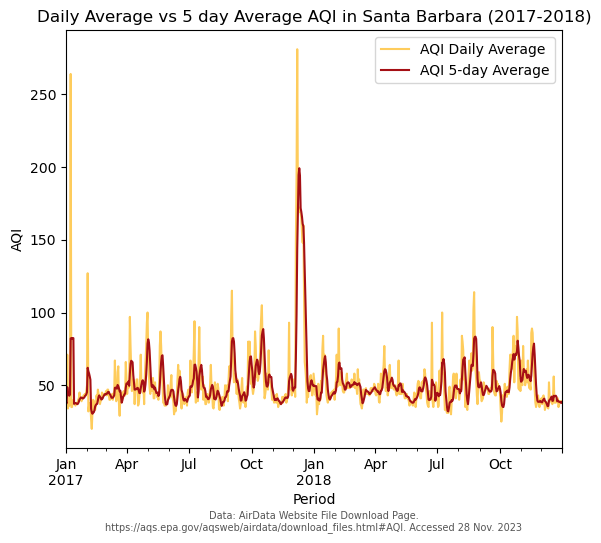

In [67]:
# plot both the daily AQI and the 5-day average
fig, ax = plt.subplots()

aqi_sb.aqi.plot(ax=ax,
                color = '#fecc5c')
aqi_sb.five_day_average.plot(ax=ax,
                color = '#a50f15')

# update axis
ax.set_title('Daily Average vs 5 day Average AQI in Santa Barbara (2017-2018)')
ax.set_xlabel('Period')
ax.set_ylabel('AQI')
ax.legend(['AQI Daily Average', 'AQI 5-day Average'])

# annotate the data source
ax.annotate("Data: AirData Website File Download Page.\nhttps://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023",
            xy=(0.5, -0.15), 
            fontsize=7, 
            xycoords='axes fraction',  
            color='#555555',
            ha='center',
            va='top')  

# adjust the botton space of the figure
plt.subplots_adjust(bottom=0.01)

plt.show

#### Interpretation

From the graph we can see a significant increase in both the daily average and 5-day rolling average in December 2017 compared to the rest of the year, which coincides with the Thomas Fire event. During this period, the AQI exceeded 200, falling into the **very unhealthy** category. According to AQI standards, at this level, the risk of health effects is increased for everyone.

## Create a false color image to visualize the Thomas Fire scar

### Import geospatial data 

Data for the following two datasets is available on Google Drive in the file: [thomasfire_aqi_analysis.zip](https://drive.google.com/file/d/1lDBPBy9378Zcj1g9Huhe8F_WeP4LZ7CN/view?usp=sharing). 

#### Import Landsat geospatial data (netCDF)

In [68]:
# use rioxarray library to import netCDF file with geospatial features
fp_lsat = 'data/landsat8-2018-01-26-sb-simplified.nc'
lsat = rioxr.open_rasterio(fp_lsat)

#### Import California fire perimeter shape file

In [69]:
# use geopandas to import shape file with California fire perimeters 
calfire = gpd.read_file(os.path.join(os.getcwd(), 'data', 
                                     'California_Fire_Perimeters_2017',
                                     'California_Fire_Perimeters_2017.shp'))  

### Prepare geospatial data <a id="section-8-prep_geodata"></a>

First, let's inspect geospatial datasets.

In [70]:
%%capture

# explore shape file

# view shape and data type
print(f'calfire dataset shape: {calfire.shape}')
print(f'calfire dataset crs: {calfire.crs}')

# view the first two records of imported shape file data
calfire.head(2)

# visualize calfire data
calfire.plot(color = 'none')


#### Create a new dataframe with Thomas Fire scar geometries

California fire perimeter dataset includes the list of all fires in California during 2017. 
For our analysis, we are interested only in Thomas fire that occured that year.

Therefore, we need to filter the dataset to the rows with Thomas fire.

**Note**: We only have one record with `fire_name = "THOMAS"` in the dataframe. 
This is the record that contains the geometries of the Thomas Fire scar.

In [71]:
# update the column names case to snake_case
calfire.columns = calfire.columns.str.lower().str.replace(' ','_')

# find the value that corresponds to Thomas fire
calfire[calfire.fire_name.str.contains('Thomas', case=False, na=False)]['fire_name'].unique()

# create a new dataframe with Thomas fire details
tf = calfire[calfire.fire_name == 'THOMAS']
# keep only required fields
tf = tf.loc[:, ['fire_name', 'gis_acres', 'shape_leng','shape_area','geometry']]


#### Reproject CRS

⚠️ Important:

1. In order to overlay the Thomas Fire perimeter on the Santa Barbara County land cover, we need to ensure that the CRSs of the two datasets are the same. To achieve this, we will reproject the CRS of the tf dataset into the CRS of the lsat dataset.

2. The lsat dataset includes an additional dimension, the band, which makes it a 3-dimensional object. We are going to convert it into a 2-dimensional dataset by dropping the band dimension.

In [72]:
%%capture

# check that crs of the shape file and netCDF match
calfire.crs == lsat.rio.crs

# update CRS of the shape file to lsat CRS
tf = tf.to_crs(crs = lsat.rio.crs)
print(f'CRS of the lsat and tf datasets match: {tf.crs == lsat.rio.crs}')

# drop an extra dimension "band" from lsat dataset
lsat = lsat.squeeze().drop('band')
# check that band dimension has been dropped
print(f'After squeeze:\ndimensions {lsat.dims}\ncoords: {lsat.coords}')

### Create a false color image of Thomas Fire Scar

In the final step we will create a map showing the shortwave infrared/nir/ ed false color image together with the Thomas fire perimeter. 

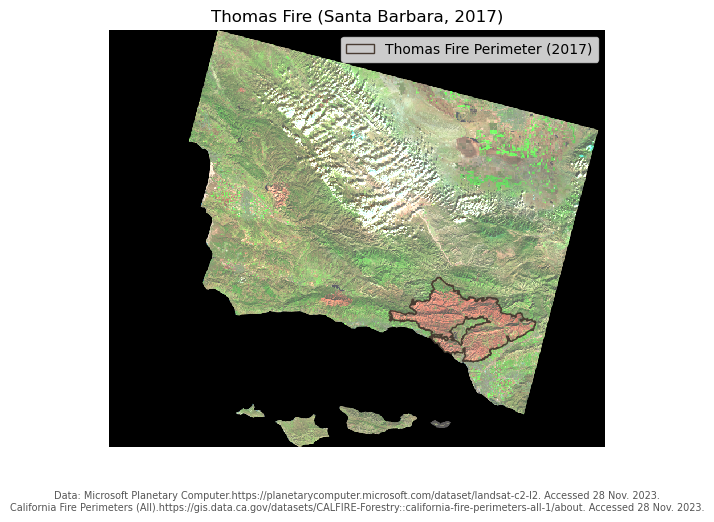

In [73]:
fig, ax = plt.subplots()

# remove axis
ax.axis('off')

# plot Thomas fire perimeter
tf.plot(ax=ax, color='none', edgecolor = '#483C32')
tf_patch = mpatches.Patch(facecolor = 'none', 
                          edgecolor='#483C32', 
                          label='Thomas Fire Perimeter (2017)')

# plot raster image of Santa Barbara area
lsat[['swir22', 'nir08', 'red']].to_array().plot.imshow(ax=ax, robust = True)

# add legend
ax.legend(handles=[tf_patch], frameon=True, loc='upper right')
ax.set_title('Thomas Fire (Santa Barbara, 2017)')

# annotate the data source
ax.annotate("Data: Microsoft Planetary Computer.https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.\nCalifornia Fire Perimeters (All).https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023.",
            xy=(0.5, -0.15),  # Move the annotation lower to leave space for the x-axis title
            fontsize=7, 
            xycoords='axes fraction',  
            color='#555555',
            ha='center')  

# adjust the botton space of the figure
plt.subplots_adjust(bottom=0.01)

# display map
plt.show()

### Citations:
[1] AirData Website File Download Page. https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI. Accessed 28 Nov. 2023.<br>
[2] “Thomas Fire.” Wikipedia, 9 Nov. 2023. Wikipedia, https://en.wikipedia.org/w/index.php?title=Thomas_Fire&oldid=1184323284.<br>
[3] Microsoft Planetary Computer. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2. Accessed 28 Nov. 2023.<br>
[4] California Fire Perimeters (All). https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-fire-perimeters-all-1/about. Accessed 28 Nov. 2023.